<a href="https://colab.research.google.com/github/z-tufekci/DeepLearning/blob/main/ResNet_for_Face_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=25, resize=0.5)
X = lfw_people.images
n_samples, h, w = lfw_people.images.shape
y = lfw_people.target
target_names = lfw_people.target_names
#print(target_names)
n_classes = target_names.shape[0]
print("# of class: ",n_classes)
print("# of samples: ",n_samples)
print("Image size: ",h,"x",w)

# of class:  42
# of samples:  2588
Image size:  62 x 47


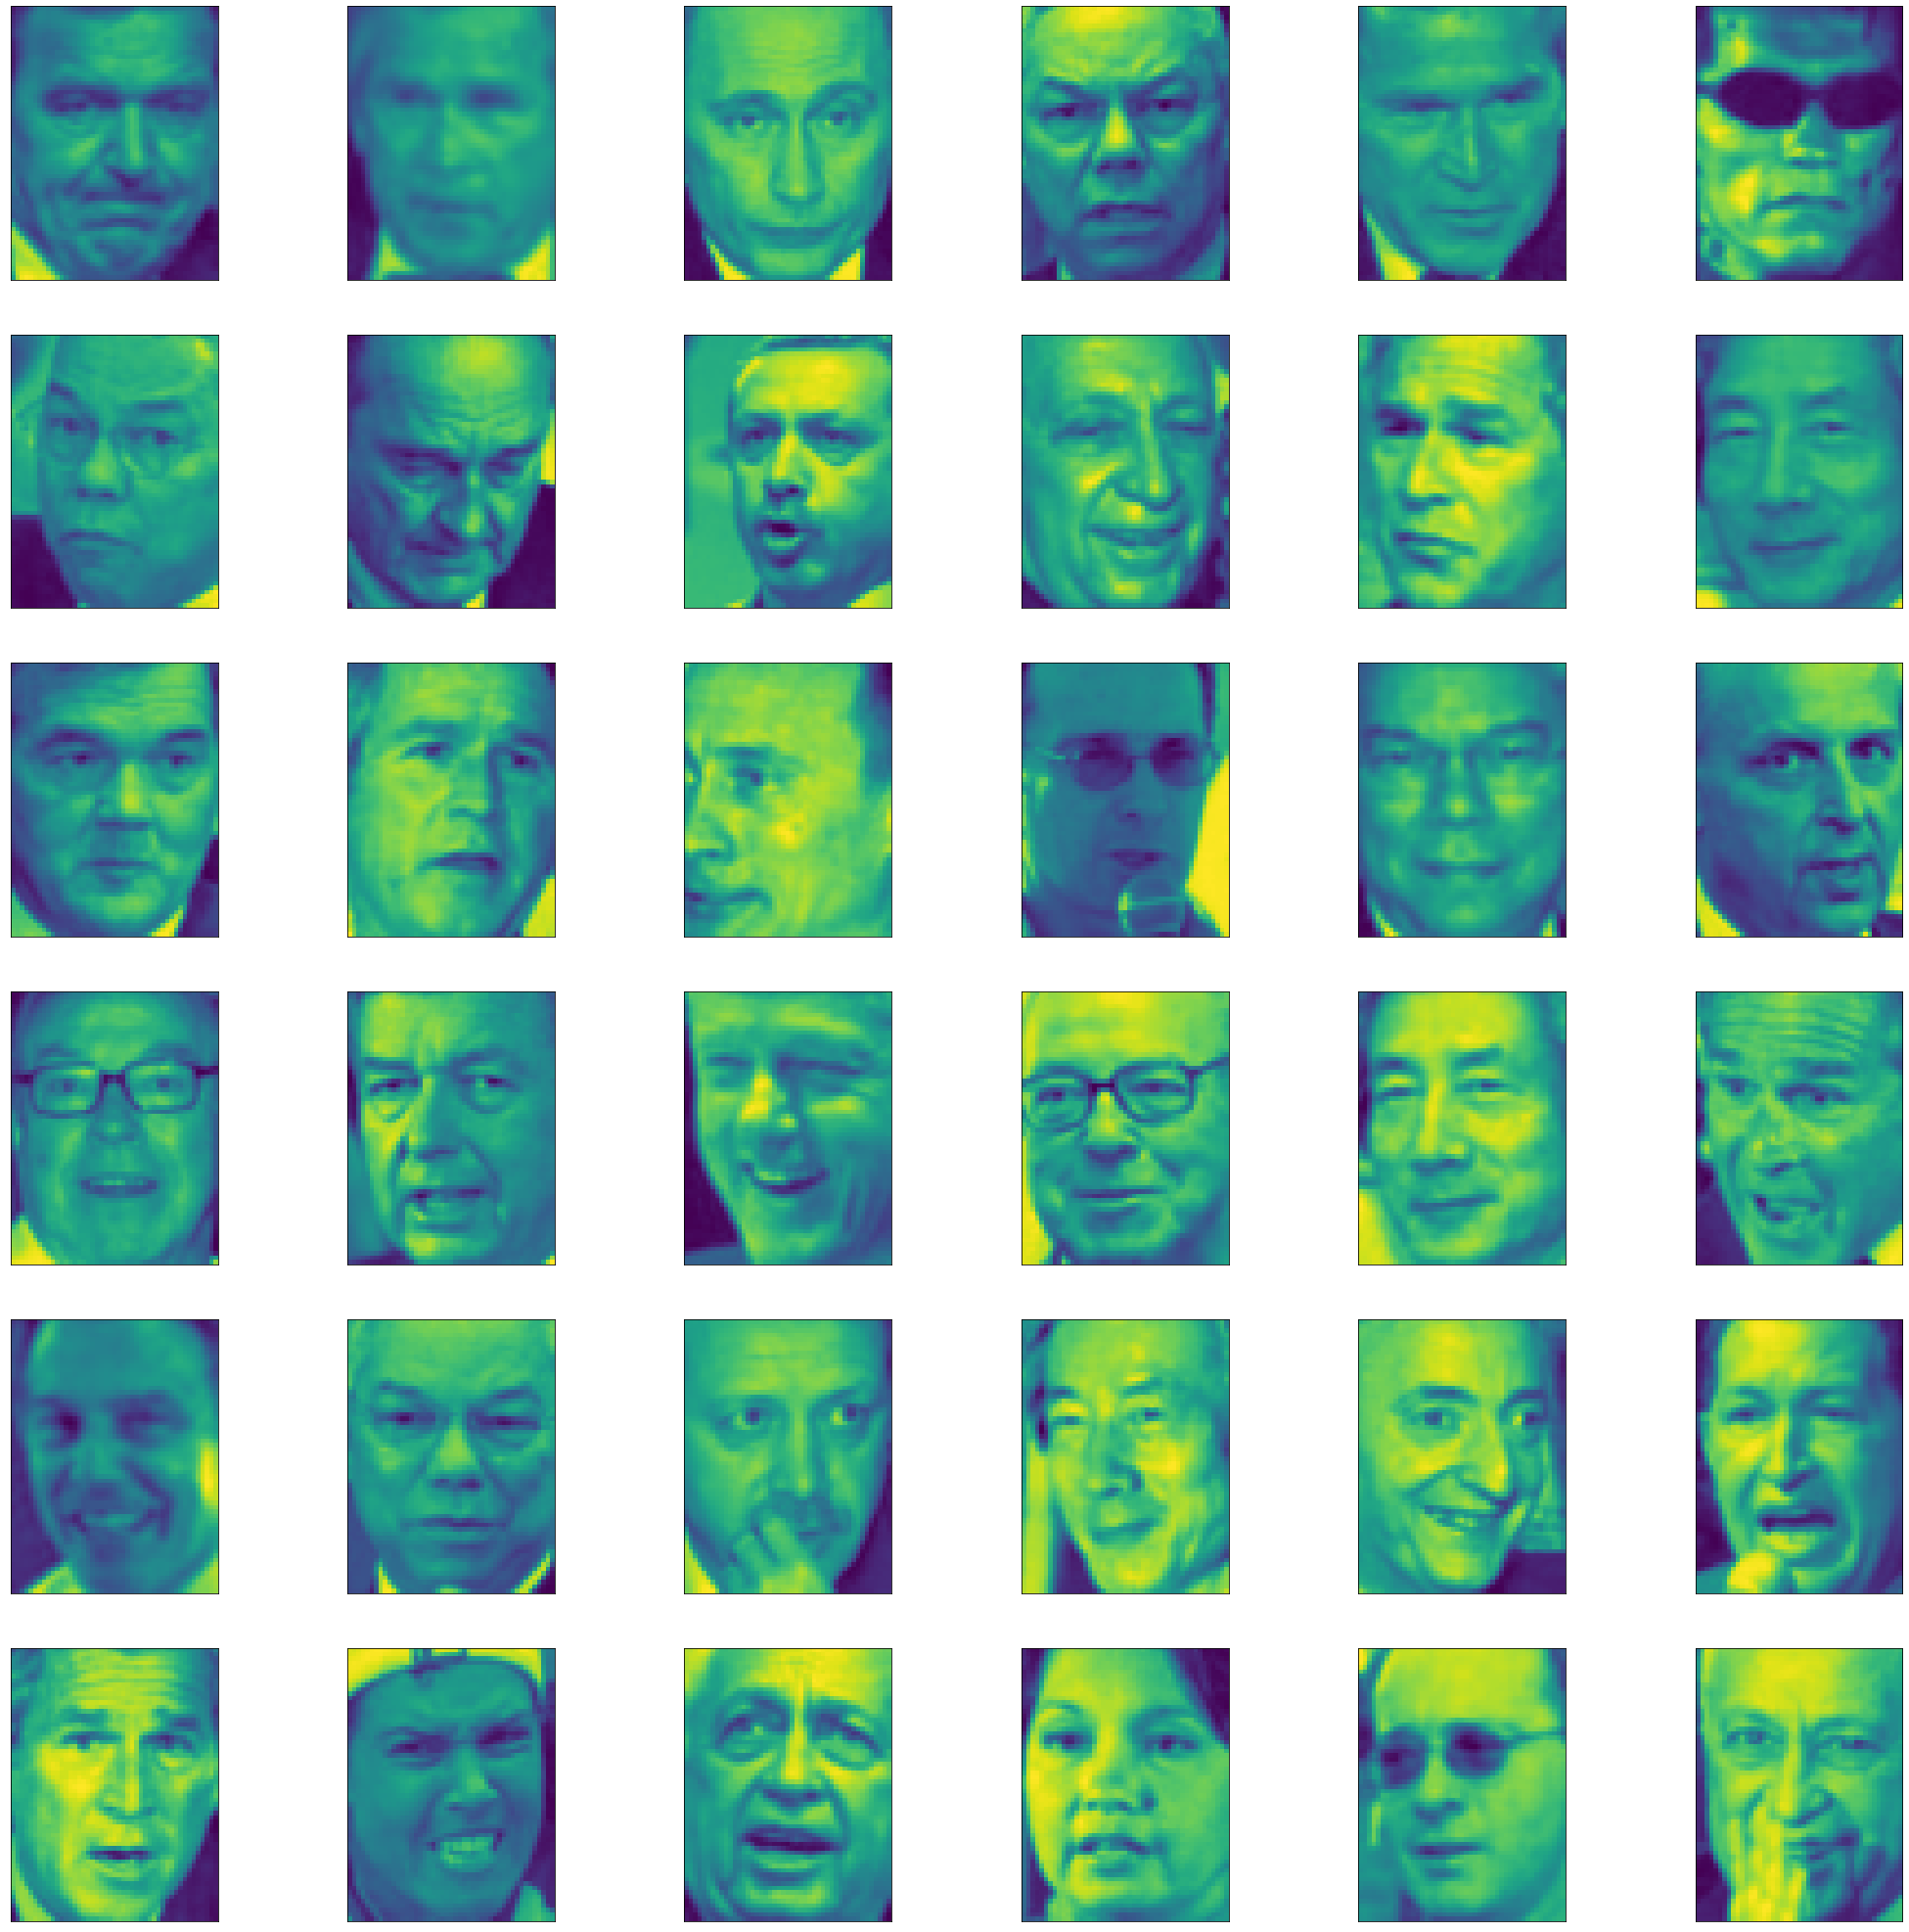

In [ ]:
import matplotlib.pyplot as plt
fig,axs = plt.subplots(6,6,figsize=(36,36))
for i in range(36):
    r=i//6
    c=i%6
    axs[r][c].set_xticks([])
    axs[r][c].set_yticks([])
    axs[r][c].imshow(X[i])
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=41)

In [ ]:
import tensorflow as  tf
y_train = tf.keras.utils.to_categorical(y_train, num_classes=n_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=n_classes)

In [ ]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import numpy as np
import os
from math import ceil
from keras.utils import np_utils

In [ ]:
batch_size = 64 
epochs = 200

num_classes = n_classes
subtract_pixel_mean = True

n_points = len(X_train)
print('n_points:' , n_points, 'batch_size:', batch_size)
steps_per_epoch = ceil(n_points / batch_size)
print('stepper_epoch:' , steps_per_epoch)

if subtract_pixel_mean:
    X_train_mean = np.mean(X_train, axis=0)
    X_train -= X_train_mean
    X_test -= X_train_mean

print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)


n_points: 2070 batch_size: 64
stepper_epoch: 33
x_train shape: (2070, 62, 47)
2070 train samples
518 test samples
y_train shape: (2070, 42)


In [ ]:
X_train = X_train.reshape(list(X_train.shape) + [1])
input_shape = X_train.shape[1:]

In [ ]:
print('y_train shape:', y_train.shape)

y_train shape: (2070, 42)


In [ ]:
def lr_schedule(epoch):  
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [ ]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
  
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same', #We want to maintain the shape same during block
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))
    print(" activation: ", activation," bn: ", batch_normalization," kernelsize: ", kernel_size," stri ", strides,"  number of filters",num_filters)
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [ ]:
def resnet_v1(input_shape, depth, num_classes=34):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    print("INPUT CNN LAYER")
    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs) # CONV2D
    for stack in range(3):    #STACK=3     STACK0: BLOCK0 --> STACK1: BLOCK0 -->stride=2(divide size by 2) kernel1 STACK2: BLOCK0 stride=2(divide size by 2) kernel1
       print("STACK",stack+1)
       for res_block in range(num_res_blocks): #BLOCK=1
            strides = 1

            if stack > 0 and res_block == 0:
                strides = 2
                print("DOWNSAMPLING") 
            
            print("   BLOCK",res_block+1)
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)

            if stack > 0 and res_block == 0: 
                print("KERNEL SIZE 1x1")
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            print("CONCATENATE")
            x = keras.layers.add([x, y])
            print("ACTIVATION RELU" )
            x = Activation('relu')(x)
            print("END OF BLOCK" )
       print("num_filters x 2")     
       num_filters *= 2
       print("END OF STACK" )
    print("AVERAGE POOLING" ) 
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)
   
    model = Model(inputs=inputs, outputs=outputs)
    return model  

In [ ]:
def resnet_v2(input_shape, depth, num_classes=34):

    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')

    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    for stage in range(3):   # resnet_layer, st0: n=3  16->64 cnnxx 64->128  st1: st2: 
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                print("KERNEL SIZE 1")
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    y = Dense(512, activation = 'relu')(y)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
n = 9 # block number
version = 1
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2
model_type = 'ResNet%dv%d' % (depth, version)
print(model_type)

ResNet56v1


In [ ]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth, num_classes=n_classes)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth, num_classes=n_classes)

INPUT CNN LAYER
 activation:  relu  bn:  True  kernelsize:  3  stri  1   number of filters 16
STACK 1
   BLOCK 1
 activation:  relu  bn:  True  kernelsize:  3  stri  1   number of filters 16
 activation:  None  bn:  True  kernelsize:  3  stri  1   number of filters 16
CONCATENATE
ACTIVATION RELU
END OF BLOCK
   BLOCK 2
 activation:  relu  bn:  True  kernelsize:  3  stri  1   number of filters 16
 activation:  None  bn:  True  kernelsize:  3  stri  1   number of filters 16
CONCATENATE
ACTIVATION RELU
END OF BLOCK
   BLOCK 3
 activation:  relu  bn:  True  kernelsize:  3  stri  1   number of filters 16
 activation:  None  bn:  True  kernelsize:  3  stri  1   number of filters 16
CONCATENATE
ACTIVATION RELU
END OF BLOCK
   BLOCK 4
 activation:  relu  bn:  True  kernelsize:  3  stri  1   number of filters 16
 activation:  None  bn:  True  kernelsize:  3  stri  1   number of filters 16
CONCATENATE
ACTIVATION RELU
END OF BLOCK
   BLOCK 5
 activation:  relu  bn:  True  kernelsize:  3  stri  1 

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])

Learning rate:  0.001


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 62, 47, 1)]  0           []                               
                                                                                                  
 conv2d_57 (Conv2D)             (None, 62, 47, 16)   160         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_55 (BatchN  (None, 62, 47, 16)  64          ['conv2d_57[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 62, 47, 16)   0           ['batch_normalization_55[0]

In [ ]:
lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
callbacks = [lr_reducer, lr_scheduler]

In [ ]:
data_augmentation = True

In [ ]:
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        zca_epsilon=1e-06,
        rotation_range=0,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.,
        zoom_range=0.,
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)

    datagen.fit(X_train)

    model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                        validation_data=(X_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        steps_per_epoch=steps_per_epoch, 
                        callbacks=callbacks)

Using real-time data augmentation.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Learning rate:  0.001
Epoch 1/200
33/33 [==============================] - 22s 347ms/step - loss: 4.4737 - accuracy: 0.1836 - val_loss: 144.2833 - val_accuracy: 0.0174 - lr: 0.0010
Learning rate:  0.001
Epoch 2/200
33/33 [==============================] - 10s 293ms/step - loss: 3.4974 - accuracy: 0.2382 - val_loss: 12.2281 - val_accuracy: 0.0270 - lr: 0.0010
Learning rate:  0.001
Epoch 3/200
33/33 [==============================] - 10s 292ms/step - loss: 3.1831 - accuracy: 0.3116 - val_loss: 6.4698 - val_accuracy: 0.0309 - lr: 0.0010
Learning rate:  0.001
Epoch 4/200
33/33 [==============================] - 10s 293ms/step - loss: 2.8826 - accuracy: 0.3667 - val_loss: 5.2948 - val_accuracy: 0.0830 - lr: 0.0010
Learning rate:  0.001
Epoch 5/200
33/33 [==============================] - 10s 293ms/step - loss: 2.5321 - accuracy: 0.4522 - val_loss: 4.6934 - val_accuracy: 0.1950 - lr: 0.0010
Learning rate:  0.001
Epoch 6/200
33/33 [==============================] - 11s 330ms/step - loss: 2.20

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=3)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.7007238864898682
Test accuracy: 0.9208494424819946
